Spectrum estimation for radiation sccatering experiment
=======================================================

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt

from vectorized_data import VectorizedData
from linear_measurement import *
from total_square_variation import *
from empirical_parameter import *
from admm import ADMMSolver
from cross_validation import CrossValidationManager

# Set intensity and spectrum
In inelastic scattering experiments, the intensity signals we can measure are given as 
$$
I(Q_0, E_0) = \int R(Q_0,E_0,Q,E) S(Q,E) dQ dE, 
$$
where $Q_0$ and $E_0$ ($Q$ and $E$) are momentum and energy transfer in measured intensity (original spectrum), respectively.

With discretizing momentum and energy space, the above equation can be represented as a linear measurement problem $\boldsymbol{I} = \boldsymbol{R}\boldsymbol{S}.$

### Parameters

    Q_min  : minimum momentum
    Q_max  : maximum momentum
    Q_grid : mesh size for momentum
    E_min  : mainimum energy
    E_max  : maximum energy
    Q_grid : mesh size for energy
    value_min  : minimum value of intensity
    value_max  : maximum value of intensiy
    
    dQ : resolution for momentum
    dE : resolution for energy

Artificial data

### Set spectrum, intensity, and measurement matrix

In [78]:
from test import get_measurement_setup

In [128]:
dQ, dE = 0.1, 0.1
gamma = 0.1
spectrum_true, spectrum, intensity, measurement_matrix = get_measurement_setup(
        alpha=0.1, Gamma=gamma, dQ=dQ, dE=dE, defect=True)
#spectrum_true, spectrum, intensity, measurement_matrix = get_measurement_setup(
#        alpha=5.0, Gamma=gamma, dQ=dQ, dE=dE, defect=True)

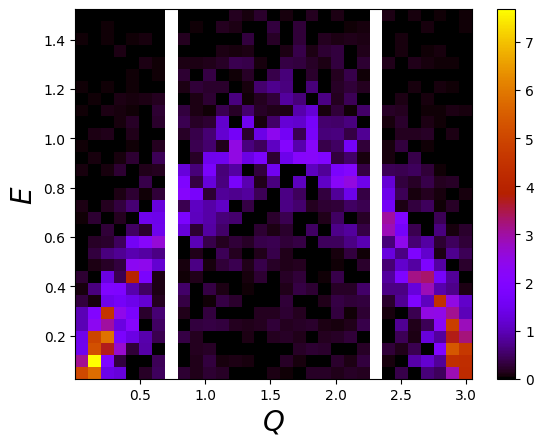

In [129]:
intensity.plot(blank=True)

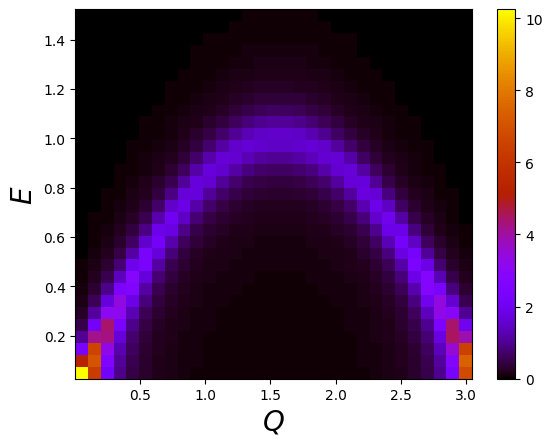

In [130]:
spectrum_true.plot()

### Weight array

In [131]:
weight = get_weight(intensity)

# Total square variation (TSV)
TSV leads to the smooth spectrum. The coefficients of TSV is defined as
$$
{\rm TSV}(x) = \sum_{i} \sum_{j} (x(i,j) - x(i+1,j))^2 + (x(i,j) - x(i,j+1))^2
$$.

In [132]:
tsvQ, tsvE = get_tsv_array(spectrum.size, spectrum.Qsize, spectrum.Esize)

# L1 norm and Total Square Variation (L1-TSV)
For reconstructing the original spectrum, we consider L1-TSV which is given as
$$
\boldsymbol{S}^* = {\rm min} \sum_{i} \frac{1}{2\sigma^2_i}  (I_i - \sum_{j}R_{i,j}S_j)^2
+ \lambda_1 |\!| \boldsymbol{S} |\!|_1 + \frac{\lambda_2}{2}{\rm TSV}(\boldsymbol{S})
$$.

We explore the optimal solution with ADMM algorithm.

### Hyper paramaeters $l_1$ and $l_2$ with the empirical way

$$
l_1 = \sqrt{R^T W R} \\

l_2 = l_1 \times 10^{-2.5}
$$

In [133]:
eta = 0.5
l2_emp = get_empirical_tsv_parameter(measurement_matrix, weight, eta=eta)
print(l2_emp)

0.8484460511095498


In [134]:
admm = ADMMSolver()
spectrum.value = admm.fit(
    intensity.value,
    measurement_matrix, 
    weight, 
    tsvQ, 
    tsvE, 
    l1=0.01, 
    l2=l2_emp)

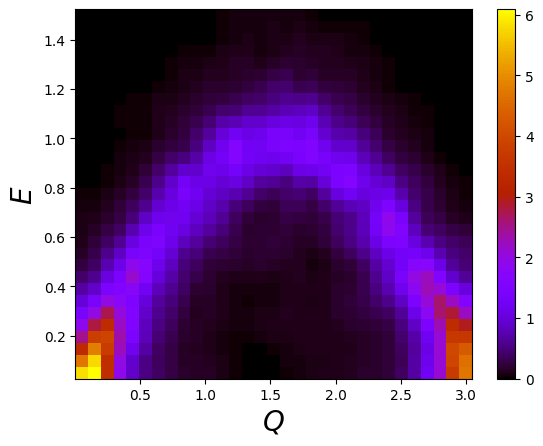

In [135]:
spectrum.plot(blank=False)

# Cross validation for parameter tuning

In [136]:
min_Q = 0.05
max_Q = 3.0
grid_Q = (max_Q-min_Q)/30
min_E = 0.05
max_E = 1.5
grid_E = (max_E-min_E)/30

#### Full CV

In [137]:
spectrum_cv = VectorizedData()
spectrum_cv.set_parameters(min_Q, max_Q, grid_Q, min_E, max_E, grid_E)

cv = CrossValidationManager(
    intensity.value, 
    measurement_matrix, 
    weight, 
    tsvQ, 
    tsvE, 
    solver=ADMMSolver(),
    num_folds=10,
    num_jobs=-1)

In [138]:
#l1_list = [10.0**i for i in np.arange(-4, 1.5, 0.5)]
#l2_list = [10.0**i for i in np.arange(-4, 1.5, 0.5)]
l1_list = [10.0**i for i in np.arange(-4, 0.25, 0.25)]
l2_list = [10.0**i for i in np.arange(-4, 0.25, 0.25)]

In [139]:
for i, v in enumerate(l1_list):
  print(i, v, np.log10(v))

0 0.0001 -4.0
1 0.00017782794100389227 -3.75
2 0.00031622776601683794 -3.5
3 0.0005623413251903491 -3.25
4 0.001 -3.0
5 0.0017782794100389228 -2.75
6 0.0031622776601683794 -2.5
7 0.005623413251903491 -2.25
8 0.01 -2.0
9 0.01778279410038923 -1.75
10 0.03162277660168379 -1.5
11 0.05623413251903491 -1.25
12 0.1 -1.0
13 0.1778279410038923 -0.75
14 0.31622776601683794 -0.5
15 0.5623413251903491 -0.25
16 1.0 0.0


In [166]:
np.log10(1.217180)

0.08535480766822079

In [140]:
cv.run_grid_search(
    l1_list, 
    l2_list)

In [141]:
idx = cv.score['mean error'].idxmin()
cv.score.iloc[idx]

l1                0.001000
l2                0.100000
mean error        0.126337
standard error    0.011487
Name: 80, dtype: float64

In [142]:
spectrum_cv.value = cv.get_best_solution(selection_mode='Lowest Error')

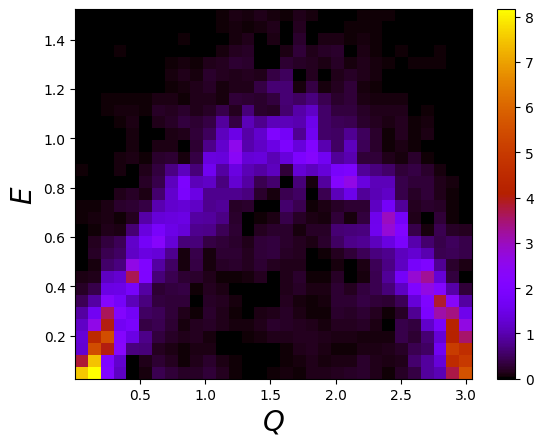

In [143]:
spectrum_cv.plot()

In [144]:
norm1 = np.sum((spectrum_cv._value - spectrum_true.value)**2)
norm2 = np.sum(spectrum_true.value**2)
nrmse = (norm1/norm2)**0.5
print(nrmse)

0.30967423615686157


#### Emp+CV

In [145]:
spectrum_emp_cv = VectorizedData()
spectrum_emp_cv.set_parameters(min_Q, max_Q, grid_Q, min_E, max_E, grid_E)

emp_cv = CrossValidationManager(
    intensity.value, 
    measurement_matrix, 
    weight, 
    tsvQ, 
    tsvE, 
    solver=ADMMSolver(),
    num_folds=10,
    num_jobs=-1)

In [146]:
eta = 0.5
l2_emp = get_empirical_tsv_parameter(measurement_matrix, weight, eta=eta)
l2_list = [l2_emp]

In [147]:
emp_cv.run_grid_search(
    l1_list, 
    l2_list)

In [148]:
idx = emp_cv.score['mean error'].idxmin()
emp_cv.score.iloc[idx]

l1                0.031623
l2                0.848446
mean error        0.158128
standard error    0.034396
Name: 10, dtype: float64

In [165]:
np.log10(emp_cv.score.iloc[idx]['l2'])

-0.0713757673124888

In [150]:
spectrum_emp_cv.value = emp_cv.get_best_solution(selection_mode='Lowest Error')

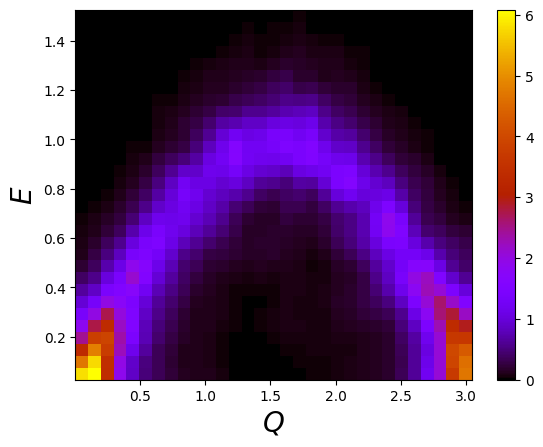

In [151]:
spectrum_emp_cv.plot()

In [152]:
norm1 = np.sum((spectrum_emp_cv.value - spectrum_true.value)**2)
norm2 = np.sum(spectrum_true.value**2)
nrmse = (norm1/norm2)**0.5
print(nrmse)

0.32640175773415936


#### Emp+LOOCV

In [153]:
spectrum_emp_loocv = VectorizedData()
spectrum_emp_loocv.set_parameters(min_Q, max_Q, grid_Q, min_E, max_E, grid_E)

emp_loocv = CrossValidationManager(
    intensity.value, 
    measurement_matrix, 
    weight, 
    tsvQ, 
    tsvE, 
    solver=ADMMSolver())

In [154]:
l2_list = [l2_emp]

In [155]:
emp_loocv.run_grid_search(
    l1_list, 
    l2_list,
    cv_type='LOOCV')

In [156]:
idx = emp_loocv.score['mean error'].idxmin()
emp_loocv.score.iloc[idx]

l1                0.177828
l2                0.848446
mean error        0.122933
standard error    0.017588
Name: 13, dtype: float64

In [157]:
spectrum_emp_loocv.value = emp_loocv.get_best_solution(selection_mode='Lowest Error')

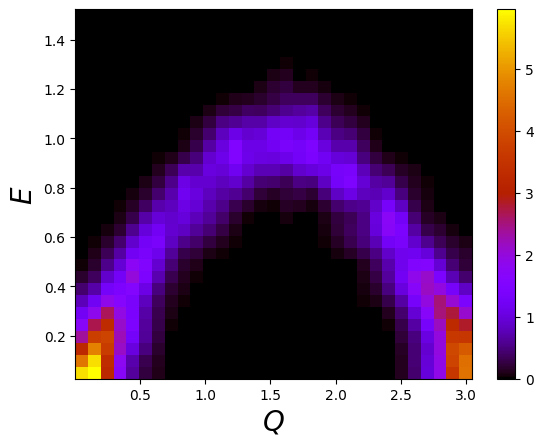

In [158]:
spectrum_emp_loocv.plot()

In [159]:
norm1 = np.sum((spectrum_emp_loocv._value - spectrum_true.value)**2)
norm2 = np.sum(spectrum_true.value**2)
nrmse = (norm1/norm2)**0.5
print(nrmse)

0.3279161793972604


## Save Data

In [160]:
import os
dir_path = f'./result/gamma={gamma}'
if os.path.isdir(dir_path):
  pass
else:
  os.mkdir(dir_path)

In [161]:
np.save(dir_path+'/true_Qmesh.npy', spectrum_true.Qmesh)
np.save(dir_path+'/true_Emesh.npy', spectrum_true.Emesh)
np.save(dir_path+'/true_value.npy', spectrum_true.value)

np.save(dir_path+'/intensity_Qmesh.npy', intensity._Qmesh)
np.save(dir_path+'/intensity_Emesh.npy', intensity._Emesh)
np.save(dir_path+'/intensity_value.npy', intensity._value)

np.save(dir_path+'/cv_Qmesh.npy', spectrum_cv.Qmesh)
np.save(dir_path+'/cv_Emesh.npy', spectrum_cv.Emesh)
np.save(dir_path+'/cv_value.npy', spectrum_cv.value)

np.save(dir_path+'/emp_cv_Qmesh.npy', spectrum_emp_cv.Qmesh)
np.save(dir_path+'/emp_cv_Emesh.npy', spectrum_emp_cv.Emesh)
np.save(dir_path+f'/emp_cv_value_eta={eta}.npy', spectrum_emp_cv.value)

np.save(dir_path+'/emp_cv_Qmesh.npy', spectrum_emp_loocv.Qmesh)
np.save(dir_path+'/emp_cv_Emesh.npy', spectrum_emp_loocv.Emesh)
np.save(dir_path+f'/emp_cv_value_eta={eta}.npy', spectrum_emp_loocv.value)

In [162]:
dir_path

'./result/gamma=0.1'